In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_stata('../../../HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [3]:
chosen_cols = [
    'time_from_met_to_rel',  # numeryczna - czas (w latach), który upłynął od poznania do wejścia w związek
    'time_from_rel_to_cohab', # numeryczna - czas (w latach), który upłynął od wejścia w związek do zamieszkania razem
    'Q25',  # jakościowa - czy uczęszczałeś z partnerem do tej samej szkoły średniej
    'Q12', # jakościowa - jak partner opisuje swoje poglądy polityczne
    'S1',  # output
]

df[chosen_cols].head()

,time_from_met_to_rel,time_from_rel_to_cohab,Q25,Q12,S1
0,0.000000,NaN,NaN,NaN,"No, I am not Married"
1,12.250000,0.500000,Different High School,Leans Republican,"Yes, I am Married"
2,0.416748,0.083252,Different High School,Leans Democrat,"Yes, I am Married"
3,1.083252,NaN,NaN,NaN,"No, I am not Married"
4,0.083252,0.833374,Different High School,Strong Democrat,"Yes, I am Married"


In [4]:
# kilka parametrów danych
print(df[chosen_cols].count())  # liczba niepustych wartości w każdej kolumnie 
print('=' * 30)
print('before drop:', len(df[chosen_cols]))
print('after drop:', len(df[chosen_cols].dropna()))  # liczba wierszy przed i po usunięciu niekompletnych wierszy

cleaner_df = df[chosen_cols].dropna()
cleaner_df['S1'] = cleaner_df['S1'].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
cleaner_df['S1'] = cleaner_df['S1'].astype('float')  # przekształcenie kolumny wynikowej do postaci 0/1
final_df = cleaner_df
final_df.head()

time_from_met_to_rel      3263
time_from_rel_to_cohab    2578
Q25                       2856
Q12                       2856
S1                        3510
dtype: int64
before drop: 3510
after drop: 2354


,time_from_met_to_rel,time_from_rel_to_cohab,Q25,Q12,S1
1,12.250000,0.500000,Different High School,Leans Republican,1.0
2,0.416748,0.083252,Different High School,Leans Democrat,1.0
4,0.083252,0.833374,Different High School,Strong Democrat,1.0
5,0.500000,0.000000,Different High School,Undecided/Independent/Other,1.0
6,0.250000,2.583374,Different High School,Leans Republican,1.0


In [5]:
X = final_df.loc[:, final_df.columns != 'S1']
y = final_df.loc[:, 'S1']

X_train = pd.get_dummies(X).sort_index(axis=1)
y_train = y

In [6]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline


columns_dict = {
    'time_from_met_to_rel': ['numeric', None],
    'time_from_rel_to_cohab': ['numeric', None],
    'Q25': ['categorical', ['Different High School', 'Same High School', 'Refused']],
    'Q12': ['categorical', ['Leans Republican', 'Leans Democrat', 'Strong Democrat',
                            'Undecided/Independent/Other', 'Not Strong Democrat', 
                            'Strong Republican', 'Not Strong Republican', 'Refused']]
}

class GetDummies(TransformerMixin):
    
    def __init__(self, columns):
        self.num_columns = [col for col in columns if columns[col][0] == 'numeric']
        self.cat_columns = [[col, columns[col][1]] for col in columns if columns[col][0] == 'categorical']
        self.col_names = self.num_columns + [f"{col}_{cat}" for col, categories in self.cat_columns 
                                                            for cat in categories]

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X, y=None, **kwargs):
        X_trans = X[self.num_columns]
        for col_name, categories in self.cat_columns:
            for cat in categories:
                X_trans.insert(len(X_trans.columns), f"{col_name}_{cat}", np.where(X[col_name] == cat, 1, 0))
                
        return X_trans

In [32]:
from sklearn.metrics import accuracy_score

forest_pipeline = Pipeline([('get_dummies', GetDummies(columns_dict))])

X_forest = forest_pipeline.fit_transform(X)
y_forest = y

forest = RandomForestClassifier(**
                                {'max_depth': 9,
                                 'max_features': 3,
                                 'min_samples_split': 2,
                                 'n_estimators': 500
                                },
                                n_jobs=-1)

forest.fit(X_forest, y_forest)
accuracy_score(y_forest, forest.predict(X_forest))

0.8445199660152931

In [35]:
predictions = forest.predict_proba(X_forest)[:, 1]
residuals = y_forest - predictions

In [111]:
from pygam import LinearGAM
import statsmodels.api as sm
lowess_sm = sm.nonparametric.lowess

def plot_residuals_correlation(model, X, y, x_axes):
    predictions = model.predict_proba(X)[:, 1]
    residuals = np.array(y - predictions)
    if x_axes == 'predictions':
        compared_var = np.array(predictions)
    else:
        compared_var = X[x_axes].values
    gam = LinearGAM().fit(compared_var.reshape((-1, 1)), residuals)
    XX = gam.generate_X_grid(term=0)
    zero_grid = np.linspace(min(XX[:, 0]), max(XX[:, 0]), 300)
    
    ret = lowess_sm(residuals, compared_var)
    
    plt.scatter(compared_var, residuals, s=2, label='data points')
    plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX), c='black', label='GAM trend line')
    plt.plot(ret[:, 0], ret[:, 1], c='orange', label='lowess', linewidth=0.9)
    plt.plot(zero_grid, np.zeros(len(zero_grid)), 'r:', label = 'y=0')
    plt.title(f"Residulas vs {x_axes}")
    plt.legend()
    plt.show()
    

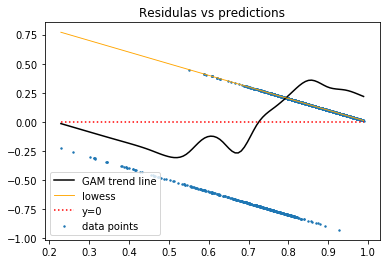

In [114]:
plot_residuals_correlation(forest, X_forest, y_forest, 'predictions')

Jak widzimy zmienna, którą chcemy przewidywać jest mocno niezbalansowana - zdecydowana większość obserwacji ma wartość 1. Widzimy, że również model zdecydowanie chętniej przewiduje wysokie wartości - praktycznie występują predykcje bliskie 0 i nawet wśród próbek, których wartość przewidywanej zmiennej to 0 zdaża się wiele predykcji z przedziału [0.5, 0.75]. Ten fakt potwierdzają również linie trendu lowess pokrywa się z predykcjami dla klasy 1, zaś GAM mocno odchyla się ku tej grupie, a nawet ją przekracza (nie potrafię tego wyjaśnić, mimo usilnych prób znalezienia błędu w kodzie).

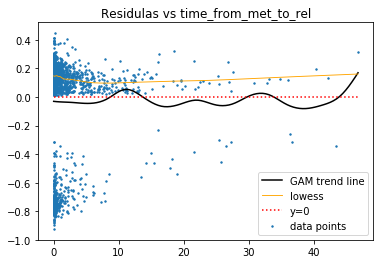

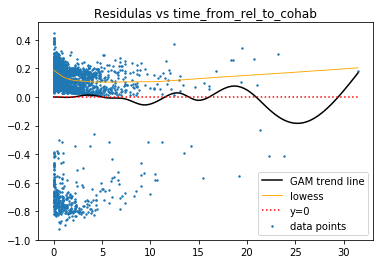

In [113]:
plot_residuals_correlation(forest, X_forest, y_forest, 'time_from_met_to_rel')
plot_residuals_correlation(forest, X_forest, y_forest, 'time_from_rel_to_cohab')

Z wykresu odczytujemy przede wszystkim fakt, że obie zmienne mają zdecydowaną większość wartości bliskich 0 i fakt iż większość próbek ma wartość przewidywanej klasy równą 1. Widzimy również, że krzywe trendu układają się wzdłuż y=0, ale są od niej różne (zwłaszcza lowess). Widzimy zatem, że obie zmienne wykazują tendencję do faworyzowania klasy 1.

In [134]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

def cooks_values(model, fresh_model, X, y):
    
    cooks_vals = []
    model_msq = mean_squared_error(y, model.predict(X))
    for idx in tqdm(X.index):
        local_model = deepcopy(fresh_model)
        X_local, y_local = X.drop(idx, axis=0), y.drop(idx, axis=0)
        local_model.fit(X_local, y_local)
        msq_diff = mean_squared_error(model.predict_proba(X_local)[:, 1], local_model.predict_proba(X_local)[:, 1])
        cooks_val = msq_diff * len(X_local) / (5 * model_msq)
        cooks_vals.append(cooks_val)
    plt.scatter(range(len(X)), cooks_vals, s=2)
    plt.show()


  6%|▌         | 147/2354 [04:45<1:13:00,  1.98s/it]


 12%|█▏        | 293/2354 [09:32<1:11:40,  2.09s/it]


 19%|█▊        | 439/2354 [14:20<1:07:00,  2.10s/it]


 25%|██▍       | 588/2354 [19:03<53:35,  1.82s/it]


 31%|███▏      | 737/2354 [44:46<52:41,  1.95s/it]


 38%|███▊      | 888/2354 [49:29<44:24,  1.82s/it]


 44%|████▍     | 1038/2354 [54:03<39:29,  1.80s/it]


 50%|█████     | 1186/2354 [58:32<40:03,  2.06s/it]


 57%|█████▋    | 1331/2354 [1:02:51<29:46,  1.75s/it]


 63%|██████▎   | 1474/2354 [1:07:00<25:44,  1.76s/it]


 69%|██████▊   | 1617/2354 [1:11:12<22:51,  1.86s/it]


 75%|███████▍  | 1760/2354 [1:15:22<17:04,  1.72s/it]


 81%|████████  | 1903/2354 [1:19:31<12:55,  1.72s/it]


 87%|████████▋ | 2046/2354 [1:23:40<08:52,  1.73s/it]


 93%|█████████▎| 2189/2354 [1:27:58<05:22,  1.95s/it]


 99%|█████████▉| 2332/2354 [1:32:39<00:51,  2.35s/it]


100%|██████████| 2354/2354 [1:33:26<00:00,  2.03s/it]

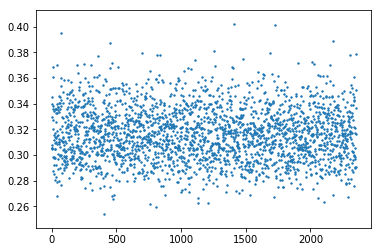

In [135]:
cooks_values(forest, RandomForestClassifier(**
                                {'max_depth': 9,
                                 'max_features': 3,
                                 'min_samples_split': 2,
                                 'n_estimators': 500
                                },
                                n_jobs=-1), X_forest, y_forest)

Jak widzimy na wykresie wartości Cooka znajdują się w pasie między 0.28 a 0.38, jednak nie są tam w żaden zauważalny regularne. Nie widać żadnych punktów, które można uznać za outlayery, co sugeruje, że model jest stabilny.